HAWC+ Data Inspection
=============
* **Aim**: Basic inspection and analysis. <br />
* **Data**: Level 4 imaging polarimetry data for 30 Dor <br />
* **Tools**: astropy <br />
* **Instrument**: HAWC+<br />
* **Documentation**: [HAWC+ Data Handbook](https://www.sofia.usra.edu/sites/default/files/Instruments/HAWC_PLUS/Documents/hawc_data_handbook.pdf).
* **Notebook repository**: https://github.com/SOFIAObservatory/Recipes

Goals
---------
* Load and plot stokes I, Q and U data
* Create polarized intensity and polization fraction maps
* Overplot polization vectors
* Create all polization maps

Introduction
--------------

This recipe provides an overview and sample python code for inspecting and plotting HAWC+ data. The data used in this example come from a SOFIA press release ([SOFIA Reveals Never-Before-Seen Magnetic Field Details](https://www.sofia.usra.edu/multimedia/science-results-archive/sofia-reveals-never-seen-magnetic-field-details)) and the data are publicly available. We will go through the inital steps for loading the level 4 polarization and creating polarization maps. 

Imports
-----------

In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from aplpy import FITSFigure
import warnings
warnings.simplefilter('ignore')
%matplotlib inline

Ingredients
----------------

Downloading HAWC+ Data

- Fill in the following fields
- Spatial constraints:
  - Coordinates or object name: `30 Dor` from drop-down menu
  - Radius: `600 arcseconds`
- Click on the arrow next to Observation Constraints to open the drop-down options. 
- Observation Constraints:
  - Observation Date: From: `2018-01-01` To: `2019-01-01`
- Instrument Constraints
  - Select `HAWC+`
- Data Product Constraints:
  - Processing Level: `Level 4`
  - Click the `Search` button
- After the results load, select the checkboxes next to the Column header AOR ID to select all data files. All files should now have a blue check indicating selection. 
- Click `Prepare Download`
- Fill in Title as `HAWC+_example_data`
- Click `Prepare Download`
- After a few minutes, the data will be downloaded locally.
- For more information, consult the [HAWC+ Data Handbook](https://www.sofia.usra.edu/sites/default/files/Instruments/HAWC_PLUS/Documents/hawc_data_handbook.pdf).

#### You can download the example data directly [here](https://zenodo.org/record/5706312/files/hawc-sample-data.zip?download=1).

SOFIA Data Organization
-----------------

After downloading the SOFIA data to your working directory you will want to unzip it, which will produce a directory structure like this:

```console
.
└── HAWC+_example_data
    ├── level4
    │   └── p5813
    │       └── F0484_HA_POL_7600018_HAWCHWPC_PMP_022-114.fits
    └── missions
        ├── 2018-07-05_HA_F481
        │   └── p5827
        │       └── F0481_HA_POL_7600012_HAWDHWPD_PMP_050-083.fits
        ├── 2018-07-07_HA_F483
        │   └── p5646
        │       └── F0483_HA_POL_7600014_HAWCHWPC_PMP_022-065.fits
        ├── 2018-07-11_HA_F484
        │   └── p5648
        │       └── F0484_HA_POL_7600017_HAWCHWPC_PMP_065-114.fits
        └── 2018-07-12_HA_F485
            └── p5658
                ├── g1
                │   └── F0485_HA_POL_76000110_HAWAHWPA_PMP_043-052.fits
                └── g2
                    └── F0485_HA_POL_7600019_HAWEHWPE_PMP_055-075.fits
```

Note the following features of this data bundle.

- Each `fits` file in the 'missions' directory corresponds to data from a single AOR (or a different filter element) obtained on a single flight
- Each subdirectory under missions corresponds to a single flight
- `fits` files under 'level4' correspond to data combined from several flights
- If multiple filters were observed on the same flight, they will be further divided into subdirectories (g1/g2 on the last line)

Note that two observations were made with the same filter (HAWC C, $89\,\mathrm{\mu m}$).  These files, `F0483_HA_POL_7600014_HAWCHWPC_PMP_022-065.fits` and `F0484_HA_POL_7600017_HAWCHWPC_PMP_065-114.fits`, were combined into one:

`level4->p5813->F0484_HA_POL_7600018_HAWCHWPC_PMP_022-114.fits`.

You can choose to keep the `fits` files nested, or copy them into one directory.

For the purpose of this basic analysis, though, let us dump all the files into one `sofia_data` directory:

```console
.
└── sofia_data
    ├── F0481_HA_POL_7600012_HAWDHWPD_PMP_050-083.fits
    ├── F0483_HA_POL_7600014_HAWCHWPC_PMP_022-065.fits
    ├── F0484_HA_POL_7600017_HAWCHWPC_PMP_065-114.fits
    ├── F0484_HA_POL_7600018_HAWCHWPC_PMP_022-114.fits
    ├── F0485_HA_POL_76000110_HAWAHWPA_PMP_043-052.fits
    └── F0485_HA_POL_7600019_HAWEHWPE_PMP_055-075.fits
```

30 Dor data
-----------

The Strategic Director's Discretionary Time (S-DDT) for SOFIA is aimed at providing the astronomical community with data sets of high scientific interest over a broadrange of potential research topics without any proprietary period.  These observingsessions allow the general user community access to high-level data products that aremeant not only for general understanding of SOFIA data and its packaging but also for inclusion in published scientific work.  The S-DDT target have been selected on a non-interference basis with existing programs and in terms of SOFIA flight planning.

The 76_0001 program, "Community Science: HAWC+ Polarimetry of 30 Dor," was designed and scheduled to provide the community with SOFIA polarimetry data of an important and relatively bright source.  The observing strategy also provided significantly increased scheduling efficiency for the OC6I (HAWC+) flights in July 2018.  The west-bound observing legs for 30 Doradus allowed a larger fraction of the highest ranked Cycle 6 targets, predominantly in the inner Galaxy, to be scheduled and flown.

This cookbook recipe follows the SOFIA press release of 30 Doradus observations: [SOFIA Reveals Never-Before-Seen Magnetic Field Details](https://www.sofia.usra.edu/multimedia/science-results-archive/sofia-reveals-never-seen-magnetic-field-details). The Level 4 reduced data from this program has been released immediately to the public and is available on the Infrared Science Archive [(IRSA)](https://irsa.ipac.caltech.edu/Missions/sofia.html).

To enhance the scientific exploitation of these data products, we present here an overview of the observations, visualizations of the data, and preliminary analysis of their quality.

Data Structure
--------------

For this analysis, we require the standard [numpy/scipy/matplotlib stack](https://scipy.org/install.html) as well the [astropy](http://docs.astropy.org/en/stable/) and [aplpy](https://aplpy.readthedocs.io/en/stable/index.html) modules.

With just a few lines of code, we can explore the HAWC+ `fits` data cubes and plot the images.

In [2]:
path = 'example_data/HAWC/'
efile = path+'F0485_HA_POL_7600019_HAWEHWPE_PMP_055-075.fits'
dfile = path+'F0481_HA_POL_7600012_HAWDHWPD_PMP_050-083.fits'
cfile = path+'F0484_HA_POL_7600018_HAWCHWPC_PMP_022-114.fits'

afile = path+'F0485_HA_POL_76000110_HAWAHWPA_PMP_043-052.fits'
hawc = fits.open(afile)
hawc.info()

Filename: example_data/HAWC/F0485_HA_POL_76000110_HAWAHWPA_PMP_043-052.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  STOKES I      1 PrimaryHDU     572   (94, 114)   float64   
  1  ERROR I       1 ImageHDU        27   (94, 114)   float64   
  2  STOKES Q      1 ImageHDU        18   (94, 114)   float64   
  3  ERROR Q       1 ImageHDU        18   (94, 114)   float64   
  4  STOKES U      1 ImageHDU        18   (94, 114)   float64   
  5  ERROR U       1 ImageHDU        18   (94, 114)   float64   
  6  IMAGE MASK    1 ImageHDU        27   (94, 114)   float64   
  7  PERCENT POL    1 ImageHDU        18   (94, 114)   float64   
  8  DEBIASED PERCENT POL    1 ImageHDU        18   (94, 114)   float64   
  9  ERROR PERCENT POL    1 ImageHDU        18   (94, 114)   float64   
 10  POL ANGLE     1 ImageHDU        18   (94, 114)   float64   
 11  ROTATED POL ANGLE    1 ImageHDU        18   (94, 114)   float64   
 12  ERROR POL ANGLE    1 ImageHDU        18   (94, 114) 

We can see above the data structure of the multi-extension `fits` files.  Each file contains 19 extensions which encapsulates all of the measurable Stokes parameters, derived polarization information, and associated errors in a single package.
<hr>

Stokes I
-------------

Stokes $I$---the zeroth extension in the `fits` file---represents the total intensity of the image.

Let us go ahead and plot this extension:

INFO: Auto-setting vmin to -9.881e-02 [aplpy.core]
INFO: Auto-setting vmax to  1.747e+00 [aplpy.core]


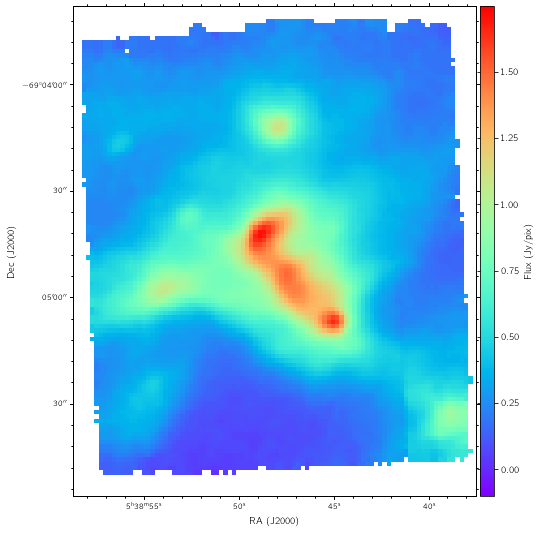

In [3]:
# set colormap for all plots
cmap = 'rainbow'

stokes_i = hawc['STOKES I']               # or hawc[0]. Note the extension is from the hawc.info() table above

axs = FITSFigure(stokes_i)                # load HDU into aplpy figure
axs.show_colorscale(cmap=cmap)            # display the data with WCS projection and chosen colormap

# FORMATTING
axs.tick_labels.set_font(size='small')

# Add colorbar
axs.add_colorbar()
axs.colorbar.set_axis_label_text('Flux (Jy/pix)');

Stokes Q and U
-----------------

Similarly, we can plot the Stokes Q and Stokes U images:

INFO: Auto-setting vmin to -7.192e-02 [aplpy.core]
INFO: Auto-setting vmax to  9.014e-02 [aplpy.core]
INFO: Auto-setting vmin to -6.312e-02 [aplpy.core]
INFO: Auto-setting vmax to  8.091e-02 [aplpy.core]


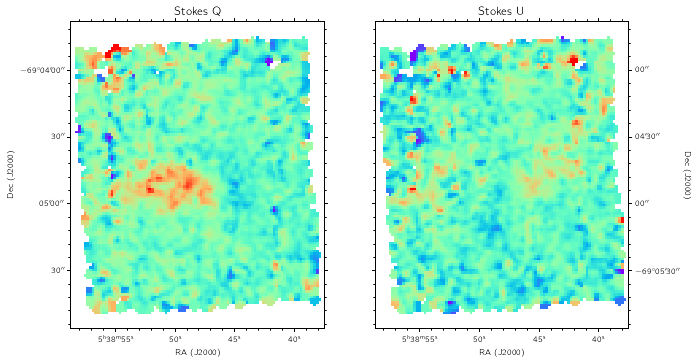

In [4]:
stokes_q = hawc['STOKES Q']
stokes_u = hawc['STOKES U']

axq = FITSFigure(stokes_q, subplot=(1,2,1))  # generate FITSFigure as subplot to have two axes together
axq.show_colorscale(cmap=cmap)               # show Q


axu = FITSFigure(stokes_u, subplot=(1,2,2),
                 figure=plt.gcf())
axu.show_colorscale(cmap=cmap)               # show U

# FORMATTING
axq.set_title('Stokes Q')
axu.set_title('Stokes U')
axu.axis_labels.set_yposition('right')
axu.tick_labels.set_yposition('right')
axq.tick_labels.set_font(size='small')
axq.axis_labels.set_font(size='small')
axu.tick_labels.set_font(size='small')
axu.axis_labels.set_font(size='small');

<hr>
We can additionally plot the associated error maps for each extension.

INFO: Auto-setting vmin to -7.005e-02 [aplpy.core]
INFO: Auto-setting vmax to  8.979e-02 [aplpy.core]
INFO: Auto-setting vmin to  3.753e-03 [aplpy.core]
INFO: Auto-setting vmax to  3.286e-02 [aplpy.core]


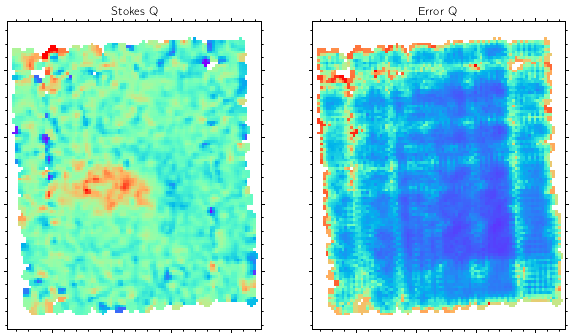

In [5]:
stokes_q = hawc['STOKES Q']
error_q = hawc['ERROR Q']

axq = FITSFigure(stokes_q, subplot=(1,2,1))  # generate FITSFigure as subplot to have two axes together
axq.show_colorscale(cmap=cmap)               # show Q


axe = FITSFigure(error_q, subplot=(1,2,2), figure=plt.gcf())
axe.show_colorscale(cmap=cmap)               # show error

# FORMATTING
axq.set_title('Stokes Q')
axe.set_title('Error Q')
axq.axis_labels.hide()                       # hide axis/tick labels
axe.axis_labels.hide()
axq.tick_labels.hide()
axe.tick_labels.hide();

Polarized Intensity Ip
---------------------

Level 4 HAWC+ additionally provides extensions with the linear polarization percentage ($p$), angle ($\theta$), and their associated errors ($\sigma$).

Percent polarization ($p$) and error ($\sigma_p$) are calculated as:

\begin{align}
    p & = 100\sqrt{\left(\frac{Q}{I}\right)^2+\left(\frac{U}{I}\right)^2} \\
    \sigma_p & = \frac{100}{I}\sqrt{\frac{1}{(Q^2+U^2)}\left[(Q\,\sigma_Q)^2+(U\,\sigma_U)^2+2QU\,\sigma_{QU}\right]+\left[\left(\frac{Q}{I}\right)^2+\left(\frac{U}{I}\right)^2\right]\sigma_I^2-2\frac{Q}{I}\sigma_{QI}-2\frac{U}{I}\sigma_{UI}}
\end{align}

Note that $p$ here represents the **percent** polarization as opposed to the more typical convention for $p$ as the **fractional** polarization.

Maps of these data are found in extensions 7 (PERCENT POL) and 9 (ERROR PERCENT POL).

Polarized intensity, $I_p$, can then be calculated as $I_p = \frac{I\times p}{100}$, which is included in extension 13 (POL FLUX).

Also included is the debiased polarization percentage ($p^\prime$) calculated as:

$p^\prime=\sqrt{p^2-\sigma_p^2}$, found in extension 8 (DEBIASED PERCENT POL).

We similarly define the debiased polarized intensity as $I_{p^\prime} = \frac{I\times p^\prime}{100}$, which is included in extension 15 (DEBIASED POL FLUX).

These values are also included in table form in extension 17 (POL DATA).

INFO: Auto-setting vmin to -1.021e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.742e+00 [aplpy.core]
INFO: Auto-setting vmin to -9.840e-03 [aplpy.core]
INFO: Auto-setting vmax to  1.092e-01 [aplpy.core]


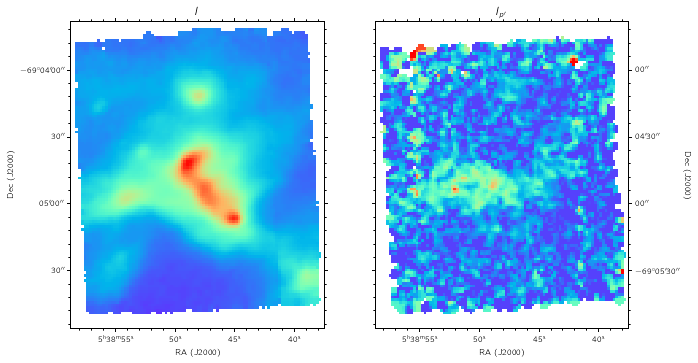

In [6]:
stokes_ip = hawc['DEBIASED POL FLUX']

axi = FITSFigure(stokes_i, subplot=(1,2,1))
axi.show_colorscale(cmap=cmap)               # show I


axp = FITSFigure(stokes_ip, subplot=(1,2,2), figure=plt.gcf())
axp.show_colorscale(cmap=cmap)               # show Ip

# FORMATTING
axi.set_title(r'$I$')
axp.set_title(r'$I_{p^\prime}$')
axp.axis_labels.set_yposition('right')
axp.tick_labels.set_yposition('right')
axi.tick_labels.set_font(size='small')
axi.axis_labels.set_font(size='small')
axp.tick_labels.set_font(size='small')
axp.axis_labels.set_font(size='small');

Plotting Polarization Vectors
---------------

From the $Q$ and $U$ maps, the polarization angle $\theta$ is calculated in the standard way:

$\theta = \frac{90}{\pi}\,\mathrm{tan}^{-1}\left(\frac{U}{Q}\right)$

with associated error:

$\sigma_\theta = \frac{90}{\pi\left(Q^2+U^2\right)}\sqrt{\left(Q\sigma_Q\right)^2+\left(U\sigma_U\right)^2-2QU\sigma_{QU}}$

The angle map is stored in extension 10 (POL ANGLE) in degrees, with its error in extension 12 (ERROR POL ANGLE).  

As part of the HAWC+ reduction pipeline, $\theta$ is corrected for the vertical position angle of the instrument on the sky, the angle of the HWP plate, as well as an offset angle that is calibrated to each filter configuration. $\theta=0^\circ$ corresponds to the North-South direction, $\theta=90^\circ$ corresponds to the East-West direction, and positive values follow counterclockwise rotation.

We also provide the PA of polarization rotated by $90^\circ$, $\theta_{90}$, in extension 11 (ROTATED POL ANGLE). This PA of polarization needs to be used with caution. If the measured polarization is dominated by magnetically-aligned dust grains, then the PA of polarization, $\theta$, can be rotated by $90^\circ$ to visualize the magnetic field morphology. For more details, see [Hildebrand et al. 2000](http://adsabs.harvard.edu/abs/2000PASP..112.1215H); [Andersson et al. 2015](http://adsabs.harvard.edu/abs/2015ARA%26A..53..501A).

We can now use the $p^\prime$ and $\theta_{90}$ maps to plot the polarization vectors.  First, however, let us make a quality cut.  Rather than defining a $\sigma$ cut on the polarization vectors themselves, it is more useful to define a signal-to-noise cut on total intensity, $I$, the measured quantity.

Starting with the propagated error on the polarization fraction:

\begin{equation*}
    \sigma_p = \frac{100}{I}\sqrt{\frac{1}{(Q^2+U^2)}\left[(Q\,\sigma_Q)^2+(U\,\sigma_U)^2+2QU\,\sigma_{QU}\right]+\left[\left(\frac{Q}{I}\right)^2+\left(\frac{U}{I}\right)^2\right]\sigma_I^2-2\frac{Q}{I}\sigma_{QI}-2\frac{U}{I}\sigma_{UI}}
\end{equation*}

Let's assume the errors in $Q$, $U$, and $I$ are comparable so that there are no covariant (cross) terms in the error expansion.

Therefore,
\begin{equation*}
\sigma_Q = \sigma_U = \sigma_{Q,U} \\
\sigma_{QI} = \sigma_{QU} = \sigma_{UI} = 0
\end{equation*}

$\require{cancel}$
\begin{align}
\sigma_p & = \frac{100}{I}\sqrt{\frac{1}{(\cancel{Q^2+U^2})}\left[\sigma_{Q,U}^2\left(\cancel{Q^2+U^2}\right)\right]+
\sigma_I^2\left(\frac{Q^2+U^2}{I^2}\right)} \\
\sigma_p & = \frac{100}{I}\sqrt{\sigma_{Q,U}^2+\sigma_I^2\left(\frac{Q^2+U^2}{I^2}\right)}=
\frac{1}{I}\sqrt{\sigma_{Q,U}^2+\sigma_I^2\,p^2}
\end{align}

If we assume that $p$ is relatively small (e.g. the source is not highly polarized), and that the errors in $I$ are small, then the second term ($\sigma_I^2\,p^2$) is negligible.

\begin{equation*}
\sigma_p = \frac{\sigma_{Q,U}}{I}
\end{equation*}

By design, the HAWC+ optics split the incident radiation into two orthogonal linear polarization states that are measured with two independent detector arrays. The total intensity, Stokes $I$, is recovered by linearly adding both polarization states. If the data is taken at four equally-spaced HWP angles, and assuming 100% efficiency of the instrument, then the uncertainty in $I$ is related to the uncertanties in $Q$ and $U$:
\begin{equation*}
\sigma_Q\sim\sigma_U\sim\sqrt{2}\,\sigma_I
\end{equation*}

This simplifies our error on $p$ to:
\begin{align}
\sigma_p &\sim \sqrt{2}\frac{\sigma_I}{I} \\
\sigma_p &\sim \frac{\sqrt{2}}{\left(S/N\right)_I}
\end{align}

If we desire an error in $p$ of $\sim0.5\%$, what is the required signal-to-noise in $I$?

\begin{align}
    \left(\mathrm{S/N}\right)_I & \sim \sqrt{2}\left(\frac{1}{\sigma_p}\right) \sim \sqrt{2}\frac{1}{0.5\%} \\
    & \sim \frac{\sqrt{2}}{0.005} \sim 283
\end{align}

So, therefore if we desire an accuracy of $\sigma_p\sim0.5\%$, we require a S/N in total intensity $I$ of $\sim283$.

This S/N cut in $I$ is very conservative.  In the Level 4 HAWC+ data, the last extension, FINAL POL DATA, contains a table of values similar to POL DATA, with somewhat less restrictive quality cuts applied.  This extension includes vectors satisfying the following three criteria:
1.  (S/N$_I$) > 200
2.  (S/N$_p$) > 3
3.  $p<50\%$

Since we include maps of all measurable polarization information with the full data set, you are free to decide on any quality cuts that satisfy your scientific needs.

In this next panel, we include a single quality cut on S/N > 100, by performing the following steps:
1.  use the Stokes $I$ image as the background for the vector plot
2.  perform a quality cut on Stokes $I/\sigma_I > 100$ to make a mask
3.  mask out low S/N vectors
4.  plot remaining polarization vectors
5.  add contours to better visualize changes in flux across the map

In [7]:
def make_polmap(filename, title=None, figure=None, subplot=(1,1,1)):
    hawc = fits.open(filename)
    p = hawc['DEBIASED PERCENT POL']    # %
    theta = hawc['ROTATED POL ANGLE']   # deg
    stokes_i = hawc['STOKES I']         # I
    error_i = hawc['ERROR I']           # error I
    
    # 1. plot Stokes I
    #  convert from Jy/pix to Jy/sq. arcsec
    pxscale = stokes_i.header['CDELT2']*3600  # map scale in arcsec/pix.  CDELT2 always in deg
    stokes_i.data /= pxscale**2
    error_i.data /= pxscale**2

    fig = FITSFigure(stokes_i, figure=figure, subplot=subplot)

    # 2. perform S/N cuts on I/sigma_I, and p/sigma_p
    i_err_lim = 100
    mask = np.where(stokes_i.data/error_i.data < i_err_lim)

    # 3. mask out low S/N vectors by setting masked indices to NaN
    p.data[mask] = np.nan

    # 4. plot vectors
    scalevec = 0.4  # 1pix = scalevec * 1% pol          # scale vectors to make it easier to see 
    fig.show_vectors(p, theta, scale=scalevec, step=2)  # step size = display every 'step' vectors
                                                        #   step size of 2 is effectively Nyquist sampling
                                                        #   --close to the beam size
    # 5. plot contours
    ncontours = 30
    fig.show_contour(stokes_i, cmap=cmap, levels=ncontours,
                     filled=True, smooth=1, kernel='box')
    fig.show_contour(stokes_i, colors='gray', levels=ncontours,
                     smooth=1, kernel='box', linewidths=0.3)

    # Show image
    fig.show_colorscale(cmap=cmap)
    
    # If title, set it
    if title:
        fig.set_title(title)

    # Add colorbar
    fig.add_colorbar()
    fig.colorbar.set_axis_label_text('Flux (Jy/arcsec$^2$)')

    # Add beam indicator
    fig.add_beam(facecolor='red', edgecolor='black',
                 linewidth=2, pad=1, corner='bottom left')
    fig.add_label(0.02, 0.02, 'Beam FWHM',
                  horizontalalignment='left', weight='bold',
                  relative=True, size='small')

    # Add vector scale
    #   polarization vectors are displayed such that 'scalevec' * 1% pol is 1 pix long
    #   must translate pixel size to angular degrees since the 'add_scalebar' function assumes a physical scale
    vectscale = scalevec * pxscale/3600
    fig.add_scalebar(5 * vectscale, "p = 5%",corner='top right',frame=True)
    
    # FORMATTING
    fig.tick_labels.set_font(size='small')
    fig.axis_labels.set_font(size='small')
    
    return stokes_i, p, mask, fig

In step 4 we are arbitrarily setting a scaling factor *scalevec* to make vectors easier to see in the figure using the FITSFigure [show\_vector](https://aplpy.readthedocs.io/en/stable/api/aplpy.FITSFigure.html#aplpy.FITSFigure.show_vectors) function. 

We are setting `show_vector`'s *scale* option using our variable *scalevec*. This should be an integer length, in pixels, of a vector with magnitude 1 in the image specified by the polarization data, *p*. If *p* specifies fractional polarization, derive a vector only from every "step" pixels.


    

INFO: Auto-setting vmin to -6.756e-02 [aplpy.core]
INFO: Auto-setting vmax to  1.187e+00 [aplpy.core]


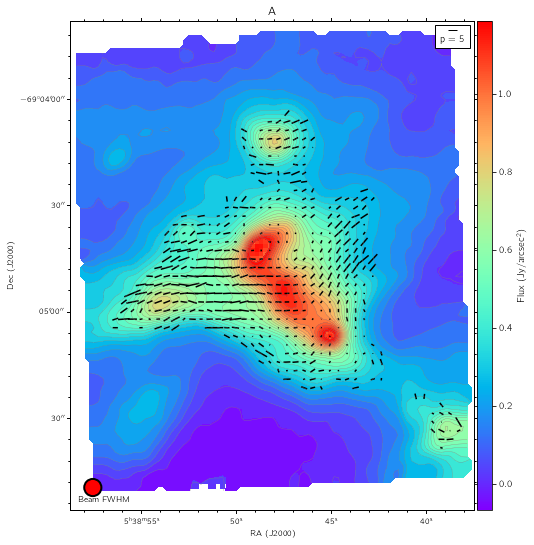

In [8]:
stokes_i, p, mask, fig = make_polmap(afile, title='A');

Plotting Polarization Fraction
--------------
We can also plot the polarization fraction $p$ to better visualize the structure of 30 Doradus.  We plot the same contours from total intensity $I$ in the background.

INFO: Auto-setting vmin to -1.012e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.123e+01 [aplpy.core]


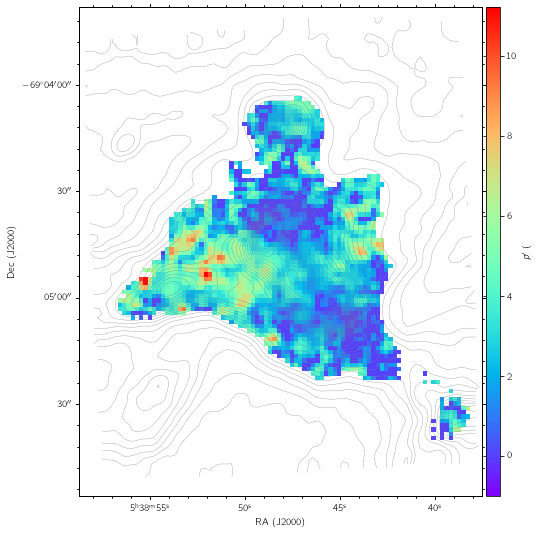

In [9]:
fig = FITSFigure(p)

# Show image
fig.show_colorscale(cmap=cmap)

# Plot contours
ncontours = 30
fig.show_contour(stokes_i, colors='gray', levels=ncontours,
                 smooth=1, kernel='box', linewidths=0.3)

# Add colorbar
fig.add_colorbar()
fig.colorbar.set_axis_label_text('$p^\prime$ (%)');

HAWC+ Polarization Maps
--------------

Finally, using the function defined above, we plot all four HAWC+ observations of 30 Doradus.

INFO: Auto-setting vmin to -6.528e-02 [aplpy.core]
INFO: Auto-setting vmax to  1.191e+00 [aplpy.core]


INFO: Auto-setting vmin to -8.454e-02 [aplpy.core]
INFO: Auto-setting vmax to  9.216e-01 [aplpy.core]


INFO: Auto-setting vmin to -2.750e-02 [aplpy.core]
INFO: Auto-setting vmax to  3.486e-01 [aplpy.core]


INFO: Auto-setting vmin to -9.768e-03 [aplpy.core]
INFO: Auto-setting vmax to  1.171e-01 [aplpy.core]


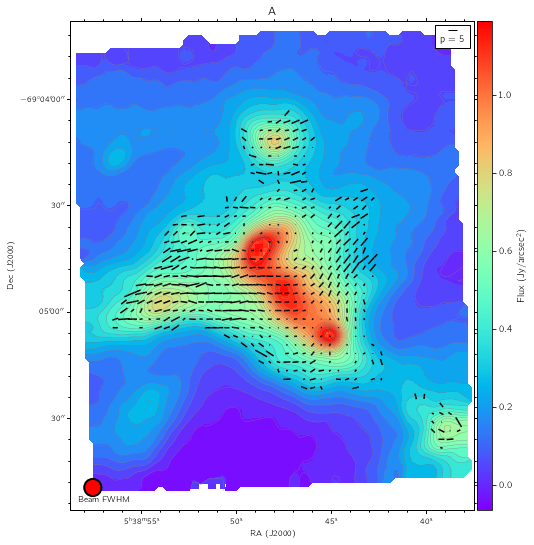

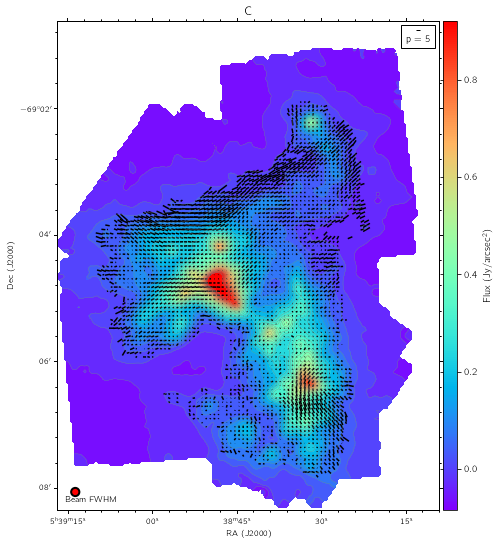

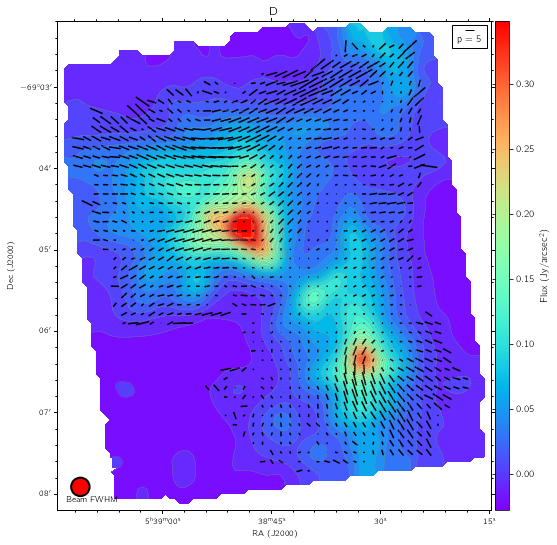

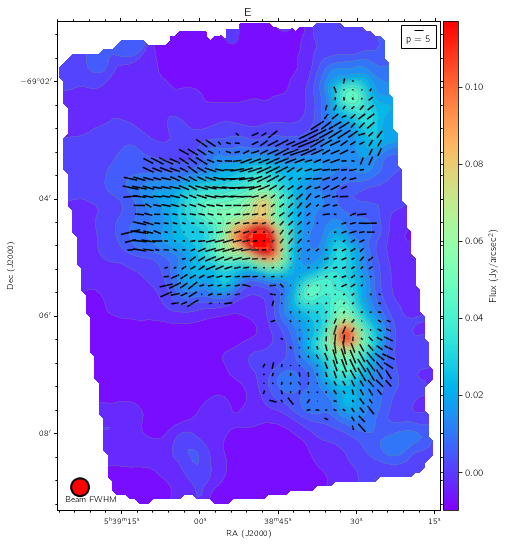

In [10]:
files = [afile,cfile,dfile,efile]
titles = ['A','C','D','E']

for file, title in zip(files,titles):
    make_polmap(file,title);